# Evaluation of Results for Synthetic Functions

In [4]:
library(ggplot2)
library(data.table)
library(BBmisc)

library(GGally)

library(ggpubr)

theme_set(theme_pubr())

In [5]:
savepath = file.path("..", "data", "runs", "synthetic")

runs = paste0("StyblinskiTang", c(2, 3, 5, 10), "D")

In [6]:
res = lapply(c(2, 3, 5), function(dimension) {
    out = lapply(c("area", "L1", "L2", "sd"), function(obj) {
        
        df = readRDS(file.path(savepath, paste0("StyblinskiTang", dimension, "D"), paste0("eval_SS_", obj, ".rds")))[n.splits == 5, ]
        
        res = lapply(seq_row(df), function(i) {
            cbind(iter = i, lambda = df$lambda[i], df$result[[i]])
        })
        
        res = do.call(rbind, res)
        res$objective = obj
        res
    })
    
    out = do.call(rbind, out)
    
    out$dimension = dimension
    out
})

In [7]:
res = do.call(rbind, res)
names(res)

[1] "iter"                     "lambda"                  
 [3] "model"                    "feature"                 
 [5] "depth"                    "conf.diff"               
 [7] "gt.diff.abs"              "gt.diff.sd"              
 [9] "gt.diff.abs.sd"           "neg_loglik"              
[11] "conf.diff.opt.1"          "gt.diff.abs.opt.1"       
[13] "conf.diff.opt.2"          "gt.diff.abs.opt.2"       
[15] "conf.diff.opt.3"          "gt.diff.abs.opt.3"       
[17] "source.conf.diff"         "source.gt.diff.abs"      
[19] "source.gt.diff.sd"        "source.gt.diff.abs.sd"   
[21] "source.neg_loglik"        "source.conf.diff.opt.1"  
[23] "source.gt.diff.abs.opt.1" "source.conf.diff.opt.2"  
[25] "source.gt.diff.abs.opt.2" "source.conf.diff.opt.3"  
[27] "source.gt.diff.abs.opt.3" "conf.rel"                
[29] "gt.rel"                   "gt.abs"                  
[31] "conf.rel.opt.1"           "gt.abs.opt.1"            
[33] "conf.rel.opt.2"           "gt.abs.opt.2"            
[35] "conf.rel.opt.3"           "gt.abs.opt.3"            
[37] "neg_loglik.rel"           "objective"               
[39] "dimension"

Show a coordinate plot that highlights the relation between dimensionality, lambda, and the performance of the final plot. 

In [8]:
# We only have a look at the "source" node here. 

df = setDT(res)

df = df[, c("iter", "depth", "objective", "lambda", "conf.diff", "neg_loglik", "neg_loglik.rel", "conf.rel", "source.conf.diff", "source.gt.diff.abs", "source.gt.diff.sd", "source.neg_loglik", "dimension")]

In [9]:
dfs = df[lambda %in% c(0.1, 2, 5)]
dfs$lambda = as.factor(dfs$lambda)
levels(dfs$lambda) = c("high", "medium", "low")

dfs$d = as.factor(dfs$dimension)

dfs = dfs[, .(`Splitted` = round(mean(neg_loglik.rel) * 100, 2), `diff.conf` = round(mean(conf.rel) * 100, 2)), by = c("lambda", "d", "depth")]

In [10]:
names(dfs)

[1] "lambda"    "d"         "depth"     "Splitted"  "diff.conf"

In [14]:
df1 = dfs[depth %in% c(2), c("lambda", "d", "diff.conf", "Splitted")]
names(df1)[3:4] = c("Red. in diff (depth 2)", "Red. in NegLoglik (depth 2)")

df2 = dfs[depth %in% c(4), c("lambda", "d", "diff.conf", "Splitted")]
names(df2)[3:4] = c("Red. in diff (depth 4)", "Red. in NegLoglik (depth 4)")

out = batchtools::ijoin(df1, df2, by = c("d", "lambda"))

write.csv(out[c(3:1, 6:4, 9:5), c(2:1, 3, 5, 4, 6)], "out.csv")

In [16]:
out[c(3:1, 6:4, 9:7), c(2:1, 3, 5, 4, 6)]

d,lambda,Red. in diff (depth 2),Red. in diff (depth 4),Red. in NegLoglik (depth 2),Red. in NegLoglik (depth 4)
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
2,low,6.44,24.82,3.57,14.50
2,medium,24.66,45.03,13.56,20.73
2,high,16.90,33.54,-1.91,3.23
3,low,7.04,15.66,2.83,7.55
3,medium,7.31,18.50,1.83,4.77
3,high,9.23,26.26,1.03,3.73
5,low,4.94,12.17,2.29,5.27
5,medium,11.79,25.97,3.05,7.75
5,high,16.27,25.47,4.83,6.71


In [17]:
library(xtable)
print(xtable(out[c(3:1, 6:4, 9:7), c(2:1, 3, 5, 4, 6)], type = "latex"), file = "out.tex")

In [500]:
p1 = ggplot(data = dfs, aes(x = lambda, y = 1 / 20 * source.conf.diff, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Sampling Bias") + ylab("Width of Confidence Bands") + theme(legend.position = "none")
p1 = p1 + geom_boxplot(data = dfs[depth == 3, ], aes(x = lambda, y = 1 / 20 * conf.diff, colour = d), linetype = "dotted")

# p2 = ggplot(data = dfs, aes(x = source.neg_loglik, y = source.gt.diff.abs, colour = d)) + geom_point()
# p2 = p2 + ylab("Error in PDP Estimate") + xlab("Avg. Negative Log-Likelihood") + theme(legend.position = "right")
p2 = ggplot(data = dfs, aes(x = lambda, y = source.neg_loglik, colour = d)) + geom_boxplot() + theme(legend.position = "right")
p2 = p2 + geom_boxplot(data = dfs[depth == 3, ], aes(x = lambda, y = neg_loglik, colour = d), linetype = "dotted")

p2 = p2 + xlab("Sampling Bias") + ylab("Negative Log-Likelihood")

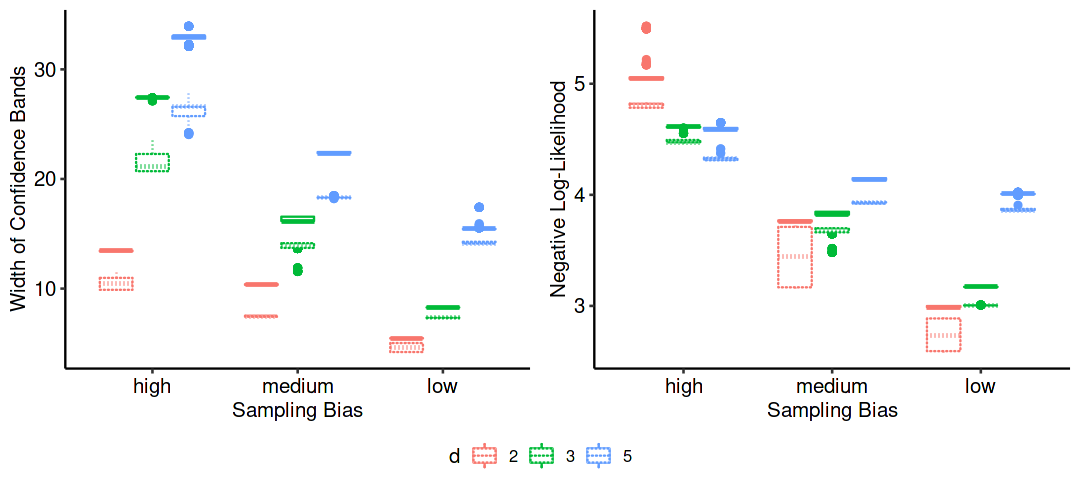

In [501]:
options(repr.plot.width = 9, repr.plot.height = 4)

p = ggarrange(p1, p2, ncol=2, common.legend = TRUE, legend="bottom")
p

ggsave(filename = "exploration_vs_confidence.png", p, width = 5, height = 3)

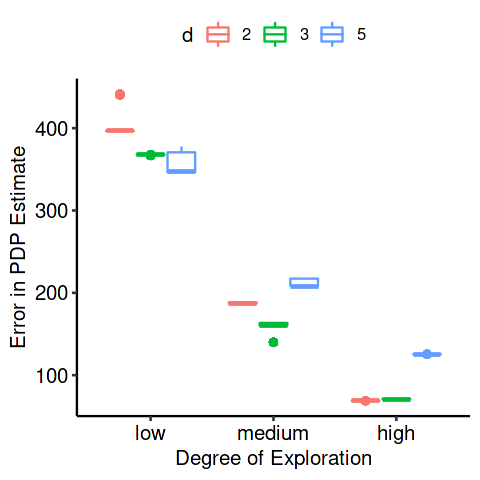

In [423]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = dfs, aes(x = lambda, y = source.gt.diff.abs, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Degree of Exploration") + ylab("Error in PDP Estimate")
p1

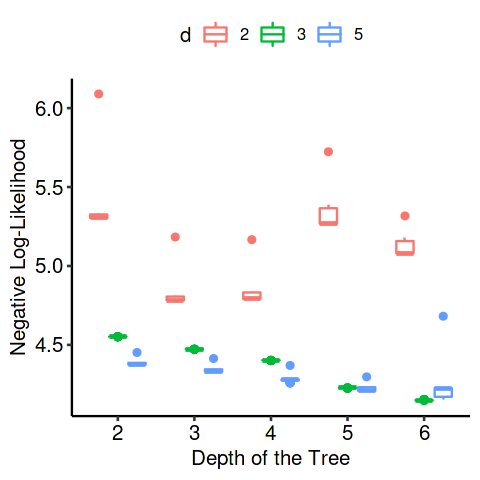

In [487]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = dfs[lambda == "high" & objective == "L1", ], aes(x = as.factor(depth), y = neg_loglik, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Negative Log-Likelihood")
p1

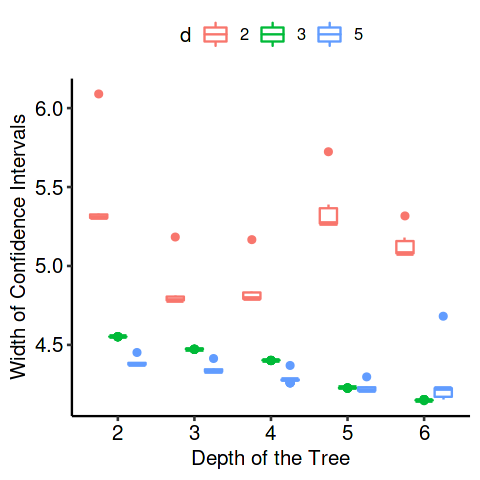

In [488]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = dfs[lambda == "high" & objective == "L1", ], aes(x = as.factor(depth), y = neg_loglik, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Width of Confidence Intervals")
p1

In [ ]:
dfs$conf.rel = - dfs$conf.rel

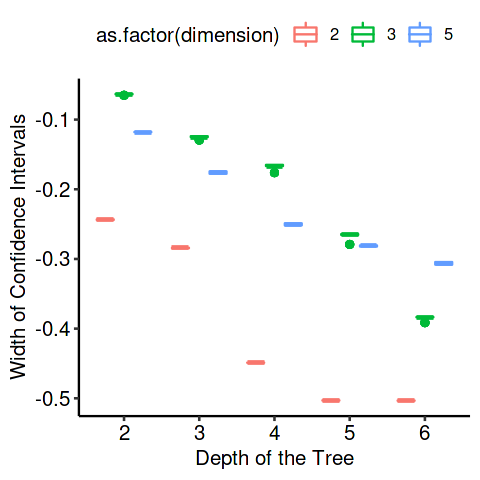

In [434]:
p1 = ggplot(data = dfs[lambda == "medium" & objective == "sd", ], aes(x = as.factor(depth), y = conf.rel, colour = as.factor(dimension))) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Width of Confidence Intervals")
p1

In [509]:
dfs

lambda,d,depth,No splitting,Splitting
<fct>,<fct>,<int>,<dbl>,<dbl>
high,2,2,5.104296,5.201740
high,2,3,5.104296,4.849246
high,2,4,5.104296,4.939562
high,2,5,5.104296,5.283249
high,2,6,5.104296,5.033001
medium,2,2,3.763985,3.253723
medium,2,3,3.763985,3.441105
medium,2,4,3.763985,2.983888
medium,2,5,3.763985,2.739244
